In [1]:
import os
import collections
import re
import math
import pathlib
import json
import functools
import operator
import time
from multiprocessing import Process
from io import StringIO
from Bio.Blast.Applications import NcbiblastnCommandline 
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import pairwise2  
from Bio.pairwise2 import format_alignment 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
FASTA_PATH='../../fasta/'
CONSENSUS_BLASTED_PATH='../../fasta/asm_out/RaTG13/'
TARGET_FILE='MN996532_2_RaTG13_complete_genome.fa'
FASTQ_PATH= '../data/'
FASTQ_FILE= 'Sars_SL3_R1_171127.fastq'
CONSENSUS_BLASTED_FILES=['RaTG13_SL3_R1_coronaspades_default.fa', 'RaTG13_SL3_R1_megahit_default.fa','RaTG13_SL3_R1_megahit_k79.fa','RaTG13_SL3_R1_megahit_kstep10_nm.fa','RaTG13_SRR11806578_SRR11806578_amplicons.fa']

In [4]:
OUT_PATH=CONSENSUS_BLASTED_PATH+'telomere_qc/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [5]:
query_file = os.path.join(FASTA_PATH, TARGET_FILE)
subject_files  = [os.path.join(CONSENSUS_BLASTED_PATH, x) for x in CONSENSUS_BLASTED_FILES]

In [6]:
fasta_target = SeqIO.read(query_file, format="fasta")
fasta_target

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTTCCAGGTAACAAACCAACGAACTCTCGATCTCTTGT...AAA'), id='MN996532.2', name='MN996532.2', description='MN996532.2 Bat coronavirus RaTG13, complete genome', dbxrefs=[])

## fastq reads

In [7]:
readlist=[]
f=FASTQ_PATH+FASTQ_FILE
start_time=time.time()
for record in SeqIO.parse(f, "fastq"):
    readlist.append(record.seq)
end_time=time.time()
print(f'{FASTQ_FILE} read took {end_time-start_time} seconds')

Sars_SL3_R1_171127.fastq read took 224.78107523918152 seconds


In [8]:
len(readlist)

11604666

In [9]:
lengths=[]
for s in readlist:
    lengths.append(len(str(s)))

Min and max read lengths

In [10]:
min(lengths), max(lengths)

(35, 151)

### Telomere like repeats

known telomentic repleat in Homo sapiens

- 'TTAGGG'

4 patterns in DNA:

- TTAGGG #G-quadruplex, direct
- GGGATT #reverse
- AATCCC #complement
- CCCTAA #antisense; reverse complement

In [11]:
TELOMERE_G='TTAGGG' 
TELOMERE_R='GGGATT' 
TELOMERE_C='AATCCC' 
TELOMERE_RC='CCCTAA' 

Singla et al. (2020) identify the following motif 

- [GGGTTGG(R)AACAGGATA(GGGTTA)n]m

and it's reverse compliment to comprise 60% of RaTG13 SRA

- [(TAACCC)nTATCCTGTT(Y)CCAACCC]m

Here we add the short telomere like sequence to the 4 patterns above.

In [12]:
TELOMERE_L_S1='GGGTTGG'
TELOMERE_L_S2='AACAGGATA' 
TELOMERE_L_S1RC='TAACCC'
TELOMERE_L_S2RC='TATCCTGTT' 
TELOMERE_L_S3RC='CCAACCC'

In [13]:
TELOMERE_SIMPLE=[TELOMERE_G, TELOMERE_R, TELOMERE_C, TELOMERE_RC, TELOMERE_L_S1, TELOMERE_L_S2, TELOMERE_L_S1RC, TELOMERE_L_S2RC, TELOMERE_L_S3RC]

In [14]:
def get_simple_tel_counts(readlist, outfile):
    lut={}
    for r in readlist:
        rs=str(r)
        for motiff in TELOMERE_SIMPLE:
            mc=rs.count(motiff)
            if motiff in lut:
                lut[motiff]+=mc
            else:
                lut.update({motiff:mc}) 
    if outfile:
        write_json(outfile, lut)

In [15]:
def write_json(fname, data):
    with open(fname, 'w') as fout:
        json.dump(data, fout)

### get Telomere counts

In [16]:
t_count=0
jobs = []
threads=10

start_time=time.time()
splits = np.array_split(readlist, threads)
print(f'split took {time.time()-start_time} seconds')

split took 1075.8210096359253 seconds


In [17]:
outfile_base=f'{OUT_PATH+FASTQ_FILE.split(".")[0]+"_simple_telomere_counts"}'
print(f'Starting {threads} mutithreading processes')
for nl in splits:
    outfile=outfile_base+'_'+str(t_count)+'.json'
    p = Process(target=get_simple_tel_counts, args=[nl, outfile])
    jobs.append(p)
    p.start()
    t_count+=1
    print(f'process {t_count} started total: {len(jobs)}', flush=True)

for p in jobs:
    p.join()

Starting 10 mutithreading processes
process 1 started total: 1
process 2 started total: 2
process 3 started total: 3
process 4 started total: 4
process 5 started total: 5
process 6 started total: 6
process 7 started total: 7
process 8 started total: 8
process 9 started total: 9
process 10 started total: 10


In [18]:
datas=[]
outfile_base=f'{OUT_PATH+FASTQ_FILE.split(".")[0]+"_simple_telomere_counts"}'
for i in range(threads):
    f = open (f'{outfile_base}_{i}.json', "r") 
    data=json.loads(f.read()) 
    datas.append(data)

In [19]:
#stack all the dicts into one
lut = {}
for dictionary in datas:
    for k, v in dictionary.items():
        if k in lut:
            lut[k] = lut[k]+v
        else:
            lut[k] = v

In [20]:
lut.values()

dict_values([38272175, 166747, 228056, 43030628, 6770209, 6209598, 43776199, 6235694, 9373408])

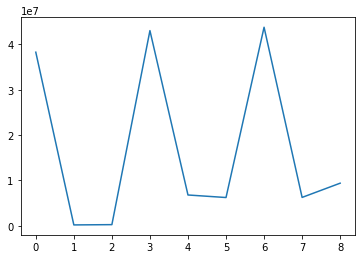

In [21]:
plt.plot(lut.values())

In [28]:
lut.keys()

dict_keys(['TTAGGG', 'GGGATT', 'AATCCC', 'CCCTAA', 'GGGTTGG', 'AACAGGATA', 'TAACCC', 'TATCCTGTT', 'CCAACCC'])

Totals of each motiff

In [22]:
tlut={}
for k,v in lut.items():
    kl=len(k)
    tlut[k]=kl*v

In [23]:
tlut.values()

dict_values([229633050, 1000482, 1368336, 258183768, 47391463, 55886382, 262657194, 56121246, 65613856])

In [24]:
key_lengths=[]
for k in lut.keys():
    key_lengths.append(len(k))

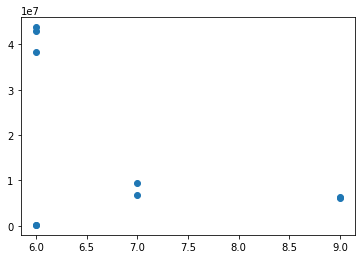

In [25]:
plt.scatter(key_lengths, lut.values())

In [26]:
### Percentage Telomere-like sequences in SRA file

In [27]:
total_chars=sum(tlut.values())
print((total_chars/sum(lengths))*100)

59.32620716372682
